# analysis_of_TCN_of_darts
* Understanding the contents of TCN model of darts

* https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html
* https://unit8co.github.io/darts/_modules/darts/models/forecasting/tcn_model.html

```python
class darts.models.forecasting.tcn_model.TCNModel(input_chunk_length, output_chunk_length,
    output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False,
     dropout=0.2, **kwargs)
```

## original codes

In [ ]:
"""
Temporal Convolutional Network
------------------------------
"""

import math
from typing import Optional, Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from darts.logging import get_logger, raise_if_not
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,
)
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
from darts.timeseries import TimeSeries
from darts.utils.data import PastCovariatesShiftedDataset
from darts.utils.torch import MonteCarloDropout

logger = get_logger(__name__)


class _ResidualBlock(nn.Module):
    def __init__(
        self,
        num_filters: int,
        kernel_size: int,
        dilation_base: int,
        dropout: float,
        weight_norm: bool,
        nr_blocks_below: int,
        num_layers: int,
        input_size: int,
        target_size: int,
    ):
        """PyTorch module implementing a residual block module used in `_TCNModule`.

        Parameters
        ----------
        num_filters
            The number of filters in a convolutional layer of the TCN.
        kernel_size
            The size of every kernel in a convolutional layer.
        dilation_base
            The base of the exponent that will determine the dilation on every level.
        dropout
            The dropout to be applied to every convolutional layer.
        weight_norm
            Boolean value indicating whether to use weight normalization.
        nr_blocks_below
            The number of residual blocks before the current one.
        num_layers
            The number of convolutional layers.
        input_size
            The dimensionality of the input time series of the whole network.
        target_size
            The dimensionality of the output time series of the whole network.

        Inputs
        ------
        x of shape `(batch_size, in_dimension, input_chunk_length)`
            Tensor containing the features of the input sequence.
            in_dimension is equal to `input_size` if this is the first residual block,
            in all other cases it is equal to `num_filters`.

        Outputs
        -------
        y of shape `(batch_size, out_dimension, input_chunk_length)`
            Tensor containing the output sequence of the residual block.
            out_dimension is equal to `output_size` if this is the last residual block,
            in all other cases it is equal to `num_filters`.
        """
        super().__init__()

        self.dilation_base = dilation_base
        self.kernel_size = kernel_size
        self.dropout1 = MonteCarloDropout(dropout)
        self.dropout2 = MonteCarloDropout(dropout)
        self.num_layers = num_layers
        self.nr_blocks_below = nr_blocks_below

        input_dim = input_size if nr_blocks_below == 0 else num_filters
        output_dim = target_size if nr_blocks_below == num_layers - 1 else num_filters
        self.conv1 = nn.Conv1d(
            input_dim,
            num_filters,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        self.conv2 = nn.Conv1d(
            num_filters,
            output_dim,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        if weight_norm:
            self.conv1, self.conv2 = (
                nn.utils.weight_norm(self.conv1),
                nn.utils.weight_norm(self.conv2),
            )

        if input_dim != output_dim:
            self.conv3 = nn.Conv1d(input_dim, output_dim, 1)

    def forward(self, x):
        residual = x

        # first step
        left_padding = (self.dilation_base**self.nr_blocks_below) * (
            self.kernel_size - 1
        )
        x = F.pad(x, (left_padding, 0))
        x = self.dropout1(F.relu(self.conv1(x)))

        # second step
        x = F.pad(x, (left_padding, 0))
        x = self.conv2(x)
        if self.nr_blocks_below < self.num_layers - 1:
            x = F.relu(x)
        x = self.dropout2(x)

        # add residual
        if self.conv1.in_channels != self.conv2.out_channels:
            residual = self.conv3(residual)
        x = x + residual

        return x


class _TCNModule(PLPastCovariatesModule):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: Optional[int],
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        target_length: int,
        dropout: float,
        **kwargs,
    ):
        """PyTorch module implementing a dilated TCN module used in `TCNModel`.


        Parameters
        ----------
        input_size
            The dimensionality of the input time series.
        target_size
            The dimensionality of the output time series.
        nr_params
            The number of parameters of the likelihood (or 1 if no likelihood is used).
        target_length
            Number of time steps the torch module will predict into the future at once.
        kernel_size
            The size of every kernel in a convolutional layer.
        num_filters
            The number of filters in a convolutional layer of the TCN.
        num_layers
            The number of convolutional layers.
        weight_norm
            Boolean value indicating whether to use weight normalization.
        dilation_base
            The base of the exponent that will determine the dilation on every level.
        dropout
            The dropout rate for every convolutional layer.
        **kwargs
            all parameters required for :class:`darts.models.forecasting.pl_forecasting_module.PLForecastingModule`
            base class.

        Inputs
        ------
        x of shape `(batch_size, input_chunk_length, input_size)`
            Tensor containing the features of the input sequence.

        Outputs
        -------
        y of shape `(batch_size, input_chunk_length, target_size, nr_params)`
            Tensor containing the predictions of the next 'output_chunk_length' points in the last
            'output_chunk_length' entries of the tensor. The entries before contain the data points
            leading up to the first prediction, all in chronological order.
        """

        super().__init__(**kwargs)

        # Defining parameters
        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_length = target_length
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base

        # If num_layers is not passed, compute number of layers needed for full history coverage
        if num_layers is None and dilation_base > 1:
            num_layers = math.ceil(
                math.log(
                    (self.input_chunk_length - 1)
                    * (dilation_base - 1)
                    / (kernel_size - 1)
                    / 2
                    + 1,
                    dilation_base,
                )
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        elif num_layers is None:
            num_layers = math.ceil(
                (self.input_chunk_length - 1) / (kernel_size - 1) / 2
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        self.num_layers = num_layers

        # Building TCN module
        self.res_blocks_list = []
        for i in range(num_layers):
            res_block = _ResidualBlock(
                num_filters=num_filters,
                kernel_size=kernel_size,
                dilation_base=dilation_base,
                dropout=dropout,
                weight_norm=weight_norm,
                nr_blocks_below=i,
                num_layers=num_layers,
                input_size=self.input_size,
                target_size=target_size * nr_params,
            )
            self.res_blocks_list.append(res_block)
        self.res_blocks = nn.ModuleList(self.res_blocks_list)

    @io_processor
    def forward(self, x_in: Tuple):
        x, _ = x_in
        # data is of size (batch_size, input_chunk_length, input_size)
        batch_size = x.size(0)
        x = x.transpose(1, 2)

        for res_block in self.res_blocks_list:
            x = res_block(x)

        x = x.transpose(1, 2)
        x = x.view(
            batch_size, self.input_chunk_length, self.target_size, self.nr_params
        )

        return x

    @property
    def first_prediction_index(self) -> int:
        return -self.output_chunk_length


[docs]class TCNModel(PastCovariatesTorchModel):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        output_chunk_shift: int = 0,
        kernel_size: int = 3,
        num_filters: int = 3,
        num_layers: Optional[int] = None,
        dilation_base: int = 2,
        weight_norm: bool = False,
        dropout: float = 0.2,
        **kwargs,
    ):
        """Temporal Convolutional Network Model (TCN).

        This is an implementation of a dilated TCN used for forecasting, inspired from [1]_.

        This model supports past covariates (known for `input_chunk_length` points before prediction time).

        Parameters
        ----------
        input_chunk_length
            Number of time steps in the past to take as a model input (per chunk). Applies to the target
            series, and past and/or future covariates (if the model supports it).
        output_chunk_length
            Number of time steps predicted at once (per chunk) by the internal model. Also, the number of future values
            from future covariates to use as a model input (if the model supports future covariates). It is not the same
            as forecast horizon `n` used in `predict()`, which is the desired number of prediction points generated
            using either a one-shot- or autoregressive forecast. Setting `n <= output_chunk_length` prevents
            auto-regression. This is useful when the covariates don't extend far enough into the future, or to prohibit
            the model from using future values of past and / or future covariates for prediction (depending on the
            model's covariate support).
        output_chunk_shift
            Optionally, the number of steps to shift the start of the output chunk into the future (relative to the
            input chunk end). This will create a gap between the input and output. If the model supports
            `future_covariates`, the future values are extracted from the shifted output chunk. Predictions will start
            `output_chunk_shift` steps after the end of the target `series`. If `output_chunk_shift` is set, the model
            cannot generate autoregressive predictions (`n > output_chunk_length`).
        kernel_size
            The size of every kernel in a convolutional layer.
        num_filters
            The number of filters in a convolutional layer of the TCN.
        weight_norm
            Boolean value indicating whether to use weight normalization.
        dilation_base
            The base of the exponent that will determine the dilation on every level.
        num_layers
            The number of convolutional layers.
        dropout
            The dropout rate for every convolutional layer. This is compatible with Monte Carlo dropout
            at inference time for model uncertainty estimation (enabled with ``mc_dropout=True`` at
            prediction time).
        **kwargs
            Optional arguments to initialize the pytorch_lightning.Module, pytorch_lightning.Trainer, and
            Darts' :class:`TorchForecastingModel`.

        loss_fn
            PyTorch loss function used for training.
            This parameter will be ignored for probabilistic models if the ``likelihood`` parameter is specified.
            Default: ``torch.nn.MSELoss()``.
        likelihood
            One of Darts' :meth:`Likelihood <darts.utils.likelihood_models.Likelihood>` models to be used for
            probabilistic forecasts. Default: ``None``.
        torch_metrics
            A torch metric or a ``MetricCollection`` used for evaluation. A full list of available metrics can be found
            at https://torchmetrics.readthedocs.io/en/latest/. Default: ``None``.
        optimizer_cls
            The PyTorch optimizer class to be used. Default: ``torch.optim.Adam``.
        optimizer_kwargs
            Optionally, some keyword arguments for the PyTorch optimizer (e.g., ``{'lr': 1e-3}``
            for specifying a learning rate). Otherwise the default values of the selected ``optimizer_cls``
            will be used. Default: ``None``.
        lr_scheduler_cls
            Optionally, the PyTorch learning rate scheduler class to be used. Specifying ``None`` corresponds
            to using a constant learning rate. Default: ``None``.
        lr_scheduler_kwargs
            Optionally, some keyword arguments for the PyTorch learning rate scheduler. Default: ``None``.
        use_reversible_instance_norm
            Whether to use reversible instance normalization `RINorm` against distribution shift as shown in [2]_.
            It is only applied to the features of the target series and not the covariates.
        batch_size
            Number of time series (input and output sequences) used in each training pass. Default: ``32``.
        n_epochs
            Number of epochs over which to train the model. Default: ``100``.
        model_name
            Name of the model. Used for creating checkpoints and saving tensorboard data. If not specified,
            defaults to the following string ``"YYYY-mm-dd_HH_MM_SS_torch_model_run_PID"``, where the initial part
            of the name is formatted with the local date and time, while PID is the processed ID (preventing models
            spawned at the same time by different processes to share the same model_name). E.g.,
            ``"2021-06-14_09_53_32_torch_model_run_44607"``.
        work_dir
            Path of the working directory, where to save checkpoints and Tensorboard summaries.
            Default: current working directory.
        log_tensorboard
            If set, use Tensorboard to log the different parameters. The logs will be located in:
            ``"{work_dir}/darts_logs/{model_name}/logs/"``. Default: ``False``.
        nr_epochs_val_period
            Number of epochs to wait before evaluating the validation loss (if a validation
            ``TimeSeries`` is passed to the :func:`fit()` method). Default: ``1``.
        force_reset
            If set to ``True``, any previously-existing model with the same name will be reset (all checkpoints will
            be discarded). Default: ``False``.
        save_checkpoints
            Whether to automatically save the untrained model and checkpoints from training.
            To load the model from checkpoint, call :func:`MyModelClass.load_from_checkpoint()`, where
            :class:`MyModelClass` is the :class:`TorchForecastingModel` class that was used (such as :class:`TFTModel`,
            :class:`NBEATSModel`, etc.). If set to ``False``, the model can still be manually saved using
            :func:`save()` and loaded using :func:`load()`. Default: ``False``.
        add_encoders
            A large number of past and future covariates can be automatically generated with `add_encoders`.
            This can be done by adding multiple pre-defined index encoders and/or custom user-made functions that
            will be used as index encoders. Additionally, a transformer such as Darts' :class:`Scaler` can be added to
            transform the generated covariates. This happens all under one hood and only needs to be specified at
            model creation.
            Read :meth:`SequentialEncoder <darts.dataprocessing.encoders.SequentialEncoder>` to find out more about
            ``add_encoders``. Default: ``None``. An example showing some of ``add_encoders`` features:

            .. highlight:: python
            .. code-block:: python

                def encode_year(idx):
                    return (idx.year - 1950) / 50

                add_encoders={
                    'cyclic': {'future': ['month']},
                    'datetime_attribute': {'future': ['hour', 'dayofweek']},
                    'position': {'past': ['relative'], 'future': ['relative']},
                    'custom': {'past': [encode_year]},
                    'transformer': Scaler(),
                    'tz': 'CET'
                }
            ..
        random_state
            Control the randomness of the weights initialization. Check this
            `link <https://scikit-learn.org/stable/glossary.html#term-random_state>`_ for more details.
            Default: ``None``.
        pl_trainer_kwargs
            By default :class:`TorchForecastingModel` creates a PyTorch Lightning Trainer with several useful presets
            that performs the training, validation and prediction processes. These presets include automatic
            checkpointing, tensorboard logging, setting the torch device and more.
            With ``pl_trainer_kwargs`` you can add additional kwargs to instantiate the PyTorch Lightning trainer
            object. Check the `PL Trainer documentation
            <https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html>`_ for more information about the
            supported kwargs. Default: ``None``.
            Running on GPU(s) is also possible using ``pl_trainer_kwargs`` by specifying keys ``"accelerator",
            "devices", and "auto_select_gpus"``. Some examples for setting the devices inside the ``pl_trainer_kwargs``
            dict:rgs``
            dict:

            - ``{"accelerator": "cpu"}`` for CPU,
            - ``{"accelerator": "gpu", "devices": [i]}`` to use only GPU ``i`` (``i`` must be an integer),
            - ``{"accelerator": "gpu", "devices": -1, "auto_select_gpus": True}`` to use all available GPUS.

            For more info, see here:
            https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags , and
            https://pytorch-lightning.readthedocs.io/en/stable/accelerators/gpu_basic.html#train-on-multiple-gpus

            With parameter ``"callbacks"`` you can add custom or PyTorch-Lightning built-in callbacks to Darts'
            :class:`TorchForecastingModel`. Below is an example for adding EarlyStopping to the training process.
            The model will stop training early if the validation loss `val_loss` does not improve beyond
            specifications. For more information on callbacks, visit:
            `PyTorch Lightning Callbacks
            <https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html>`_

            .. highlight:: python
            .. code-block:: python

                from pytorch_lightning.callbacks.early_stopping import EarlyStopping

                # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
                # a period of 5 epochs (`patience`)
                my_stopper = EarlyStopping(
                    monitor="val_loss",
                    patience=5,
                    min_delta=0.05,
                    mode='min',
                )

                pl_trainer_kwargs={"callbacks": [my_stopper]}
            ..

            Note that you can also use a custom PyTorch Lightning Trainer for training and prediction with optional
            parameter ``trainer`` in :func:`fit()` and :func:`predict()`.
        show_warnings
            whether to show warnings raised from PyTorch Lightning. Useful to detect potential issues of
            your forecasting use case. Default: ``False``.

        References
        ----------
        .. [1] https://arxiv.org/abs/1803.01271
        .. [2] T. Kim et al. "Reversible Instance Normalization for Accurate Time-Series Forecasting against
                Distribution Shift", https://openreview.net/forum?id=cGDAkQo1C0p

        Examples
        --------
        >>> from darts.datasets import WeatherDataset
        >>> from darts.models import TCNModel
        >>> series = WeatherDataset().load()
        >>> # predicting atmospheric pressure
        >>> target = series['p (mbar)'][:100]
        >>> # optionally, use past observed rainfall (pretending to be unknown beyond index 100)
        >>> past_cov = series['rain (mm)'][:100]
        >>> # `output_chunk_length` must be strictly smaller than `input_chunk_length`
        >>> model = TCNModel(
        >>>     input_chunk_length=12,
        >>>     output_chunk_length=6,
        >>>     n_epochs=20,
        >>> )
        >>> model.fit(target, past_covariates=past_cov)
        >>> pred = model.predict(6)
        >>> pred.values()
        array([[-80.48476824],
               [-80.47896667],
               [-41.77135603],
               [-41.76158729],
               [-41.76854107],
               [-41.78166819]])

        .. note::
            `DeepTCN example notebook <https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html>`_ presents
            techniques that can be used to improve the forecasts quality compared to this simple usage example.
        """

        raise_if_not(
            kernel_size < input_chunk_length,
            "The kernel size must be strictly smaller than the input length.",
            logger,
        )
        raise_if_not(
            output_chunk_length < input_chunk_length,
            "The output length must be strictly smaller than the input length",
            logger,
        )

        super().__init__(**self._extract_torch_model_params(**self.model_params))

        # extract pytorch lightning module kwargs
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)

        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.num_layers = num_layers
        self.dilation_base = dilation_base
        self.dropout = dropout
        self.weight_norm = weight_norm

    @property
    def supports_multivariate(self) -> bool:
        return True

    def _create_model(self, train_sample: Tuple[torch.Tensor]) -> torch.nn.Module:
        # samples are made of (past_target, past_covariates, future_target)
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters

        return _TCNModule(
            input_size=input_dim,
            target_size=output_dim,
            nr_params=nr_params,
            kernel_size=self.kernel_size,
            num_filters=self.num_filters,
            num_layers=self.num_layers,
            dilation_base=self.dilation_base,
            target_length=self.output_chunk_length,
            dropout=self.dropout,
            weight_norm=self.weight_norm,
            **self.pl_module_params,
        )

    def _build_train_dataset(
        self,
        target: Sequence[TimeSeries],
        past_covariates: Optional[Sequence[TimeSeries]],
        future_covariates: Optional[Sequence[TimeSeries]],
        sample_weight: Optional[Sequence[TimeSeries]],
        max_samples_per_ts: Optional[int],
    ) -> PastCovariatesShiftedDataset:
        return PastCovariatesShiftedDataset(
            target_series=target,
            covariates=past_covariates,
            length=self.input_chunk_length,
            shift=self.output_chunk_length + self.output_chunk_shift,
            max_samples_per_ts=max_samples_per_ts,
            use_static_covariates=self.uses_static_covariates,
            sample_weight=sample_weight,
        )

## Explanation

### Overview
The TCN model in Darts is used for time series forecasting. The provided code defines several classes and functions to implement this model. Here, we'll go through the main components:

1. **_ResidualBlock** class: Implements a residual block used in the TCN.

2. **_TCNModule**: class: Implements the TCN using residual blocks.

3. **TCNModel** class: The main class that integrates with Darts for time series forecasting.

## １. `_ResidualBlock` Class
This class implements a residual block, a key building block in the TCN architecture. A residual block helps to preserve information from earlier layers, making training deep networks easier.

### Initialization

```python
class _ResidualBlock(nn.Module):
    def __init__(self, num_filters, kernel_size, dilation_base, dropout, weight_norm, nr_blocks_below, num_layers, input_size, target_size):
```

* **num_filters**: Number of filters in the convolutional layers.
* **kernel_size**: Size of the convolutional kernels.
* **dilation_base**: Base of the dilation rate for the covolutions. (dilation_baseのnr_brocks_below乗がdilationの数になるので、これは基数？)
* **dropout**: Dropout rate for regularization.
* **weight_norm**: Whether to apply weight normalization.
* **nr_blocks_below**: Number of blocks below the current block. (CNN1dの層が複数有る時に、そのCNNが何層目かを表す)
* **num_layers**: Total number of covolutional layers.
* **input_size**: Size of the input time series.
* **target_size**: Size of the outpu time series.

### Components

```python
self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size, dilation=(dilation_base**nr_blocks_below))
self.conv2 = nn.Conv1d(num_filters, output_dim, kernel_size, dilation=(dilation_base**nr_blocks_below))
```

The convolutional layers are defined with dilation rates that increase exponentially based on the **dilation_base**

### Forward Pass

```python
def forward(self, x):
    residual = x
    left_padding = (self.dilation_base**self.nr_blocks_below) * (self.kernel_size - 1)
    x = F.pad(x, (left_padding, 0))
    x = self.dropout1(F.relu(self.conv1(x)))
    x = F.pad(x, (left_padding, 0))
    x = self.conv2(x)
    if self.nr_blocks_below < self.num_layers - 1:
        x = F.relu(x)
    x = self.dropout2(x)
    if self.conv1.in_channels != self.conv2.out_channels:
        residual = self.conv3(residual)
    x = x + residual
    return x
```

1. **Padding**: Adds padding to the input to maintain the outpu size.
2. **First Convolution**: Applies the first convolutional layer with ReLU activation and dropout.
3. **Second Convolution**: Applies the second convolutional layer.
4. **Residual Connection**: Adds the original input (residual) to the output, ensuring dimensions match.




### What is `num_filters` in `_ResidualBlock`

**num_filters** in the **_ResidualBlock** class represents the number of filters (or channels) used in the convolutional layers within the block. In the context of a convolutional neural network (CNN), filters are used to detect different features in the input data by applying operations.

#### Detailed Explanation:
##### Role of Filters in Convolutional Layers:
1. **Feature Detection**: Each filter in a convolutional layer is designed to detect a specific type of feature in the input data, such as edges, textures, or other patterns.
2. **Learned Parameters**: During training, the filters learn the optimal parameteers (weights) to extract relevant features from the input data.
3. **Output Channels**: The number of filters determines the number of output channels produced by convolutional layer. For example, if you have 64 filters in a convolutional layer, the output of that layer will have 64 channels.

##### In the _ResidualBlock Class:
```python
self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size, dilation=(dilation_base**nr_blocks_below))
self.conv2 = nn.Conv1d(num_filters, output_dim, kernel_size, dilation=(dilation_base**nr_blocks_below))
```

* **self.conv1**: The first convolutional layer has **num_filters** output channels.
* **self.conv2**: The second convolutional layer takes **num_filters** input channels (from **self.conv1**) and produces **output_dim** output channels.

##### Parameters:
* **num_filters**: The number of filters in the convolutional layers of the residual block. This parameter controls the number of output channels produced by a convolutional layers within the block. Increasing the number of filters generally allows the network to capture more detailed and complex features but also increase the computational cost and the number of parameters in the model.

#### Example:
If **num_filters** is set to 64, then both convolutional layers in the residual block will use 64 filters. This means:

* The first convolutional layer (**self.conv1) will output 64 feature maps.
* The second convolutional layer (**self.conv2**) will take 64 input feature maps (from **self.conv1**) and produce **output_dim** feature maps.

#### Importance of `num_filters`:
* **Capacity of the Model**: The number of filters directly affects the capacity of the model to learn and represent features in the data. More filters can capture more detailed features but require more computational resources.
* **Performance**: The choice of the number of filters is a crucial hyperparameter that can significantly impact the performance of the model. It is typically determined through experimentation and hyperparameter tuning.


In summary, **num_filters** in the **_ResidualBlock** class defines the number of convolutional filters used in the block's convolutional layers, directly influencing the feature extraction capability and the output dimensions of those layers.

### detail of `left_padding = (self.dilation_base**self.nr_blocks_below) * (self.kernel_size - 1)`

### Purpose of Padding in Convolutional Networks
In convolutional neural networks (CNNs), padding is oftern applied to the input data to cotrol the spatial dimensions of the output feature maps. Padding helps in preserving the spatial dimensions of the input, which is important for ensuring that the output feature maps have the desired dimensions.

### Dilated Convolutions
Dilated convolutions are a type of convolution where the filter is applied over a larger area than its length by skipping unput values with a certain step size. The dilation rate determines the spacing between the values in the filter.

For a convolutional layer with:

* **kernel_size**: $k$
* **dilation**: $d$

    * The effective receptive field of the filter is increasing by the dilation rate.

### Understanding the Padding Formula
The formula **`left_padding = (self.dilation_base ** self.nr_blocks_below) * (self.kernel_size - 1)`** is used to calculate the amount of padding needed to maintain the size of the input after the convolution operation. Let's break it down:

*  **self.dilation_base\*\*self.nr_blocks_below**: This calculates the dilation rate for the current block. The dilation rate increases exponentially with the block index (**self.nr_blocks_below**).

* **self.kernel_size - 1**: This term represents the number of positions the filter covers minus one. For example, with a kernel size of 3, the filter covers 3 positions, so this term would be 2.


The overall paddin ensures that the convolutional layer can process the input without reducing its size, which is crucial for maintaining the temporal dimension throughout the network.

### Data Shape Changes
Let's go through an example to see how the data shape changes with padding and convolution.

#### Example Prameters
* **kernel_size = 3**
* **dilation_base = 2**
* **nr_blocks_below = 1**
* input shape: **(batch_size, input_channels, input_length)**

#### Calculating Padding
For **nr_blocks_below = 1**

* Dilation rate = **2\*\*1 = 2**
* **left_padding = 2 * (3 - 1) = 4**

#### Applying Padding
1. **Initial Input Shape**: Let's assume the input tensor shape is **(batch_size, input_channels, input_length)**.
2. **Padding**: When padding is applied to the left (start of the sequence), the new shape becomes **(batch_size, input_channels, input_length + left_padding)**.
3. **Convolution Operation**: The padding input is then passed through a convolutional layer. The shape of the output depends on the convolutionall parameters (filters, stride, etc.), but with proper padding, the length dimension is preserved.

### Step-by-Step Example
#### 1. Initial Input Shape:
* Shape: **(batch_size, 16, 10)** (assuming `input_channels=16` and `input_length=10`)

#### 2. Padding Calculation:
* **dilation_rate = 2**
* **left_padding = 2 * (3 - 1) = 4**

#### 3. Applying Padding:
* Shape after padding: **(batch_size, 16, 10 + 4) = (batch_size, 16, 14)**

#### 4. Convolution:
* Let's assume the convolution uses **num_filters = 32** and **kernel_size = 3** with dilation rate **2**.
* The convolution operation processes the input with the given kernel size and dilation.
* If stride is 1 and proper padding is applied, the output length remains **14**.

### Summary
The formula **`left_padding = (self.dilation_base ** self.nr_blocks_below) * (self.kernel_size - 1)**` ensures that the input sequence's length is preserved after applying dilated convolutions. The padding compensates for the larger receptive field introduced by the dilation, preventing the reduction in the temporal dimension of the data. By maintaining the shape, the network can stack multiple residual blocks without altering the input length, which is essential for deep temporal convolutional networks.

### detail of `def forward(self, x)` in _ResidualBlock

It takes an input tensor `x` and processes it through a series of convolutional, activation, dropout, and residual addintion operations.

```python
def forward(self, x)
```

This defines the **forward** method, which takes a single argument **x** (the input tensor).

### 1. Save the Residual

```python
    residual = x
```

* The input tensor **x** is saved as **residual**. This is the original input that will be added back to the output after processing through the convolutional layers. This addition helps preserve the input information and stabilize training.

### 2. Calculate Padding

```python
    left_padding = (self.dilation_base**self.nr_blocks_below) * (self.kernel_size - 1)
```

* **left_padding** is calculated based on the dilation rate and kernel size. This padding ensures the output tensor has the same length as the input tensor after the convolution operation, which is crucial for maintaining the temporal dimension in a TCN.

### 3. Apply Padding and First Convolution

```python
    x = F.pad(x, (left_padding, 0))
    x = self.dropout1(F.relu(self.conv1(x)))
```

* **Padding**: **F.pad(x, (left_padding, 0))** pads the input tensor **x** on the left with **left_padding** zeros. The shape of **x** changes from **(batch_size, input_channels, input_length)** to **(batch_size, input_channels, input_length + left_padding)**.

* **First Convolution**: **self.conv1(x)** applies the first convolutional layer to the padded input. The convolution operation reduces the input length back to its original size, so the shape is **(batch_size, num_filters, input_length)**.

* **ReLU Activation**: **F.relu(...)** applies the ReLU activation function to the output of the first convolutional layer, introducing non-linearity.

* **Dropout**: **self.dropout1(...)** applies dropout for regularization, helping prevent overfitting during training.

### 4. Apply Padding and Second Convolution

```python
    x = F.pad(x, (left_padding, 0))
    x = self.conv2(x)
```

* **Padding**: **F.pad(x, (left_padding, 0))** again pads the input tensor **x** on the left with **left_padding** zeros.

* **Second Convolution**: **self.conv2(x)** applies the second convolutional layer. This layer reduces the length back to its original size, so the shape is **(batch_size, output_dim, input_length))**, where **output_dim** depends on whether it's the last residual block.

### 5. Conditional ReLU Activation

```python
    if self.nr_blocks_below < self.num_layers - 1:
        x = F.relu(x)
```

* **ReLU Activation**: If the current block is not the last block in the TCN (**self.nr_blocks_below < self.num_layers - 1**), the ReLU activtion function is applied to the output of the second convolutional layer.

### 6. Apply Second Dropout

```python
    x = self.dropout2(x)
```

* **Dropout**: **self.dropout2(x)** applies dropout to the output of the second convolutional layer.

### 7. Adjust Residual if Needed

```python
    if self.conv1.in_channels != self.conv2.out_channels:
        residual = self.conv3(residual)
```

* **Adjust Residual**: If the number of input channels to the first convolution (**self.conv1.in_channels**) is different from the number of output channels of the second convolution (**self.conv2.out_channels**), the residual is passed through a third convolutional layer (**self.conv3**) to match the dimensions. This ensures that the residual and the output of the second convolution have compatible shapes for addition.

### 8. Add Residual

```python
    x = x + residual
```

* **Add Residual**: The original input tensor (or the adjusted residual) is added to the output of the second convolution. This is the core idea of a residual block, which helps in preserving the input information and stabilizing the training of deep networks.

### 9. Return the Output

```python
    return x
```

* The final output tensor **x**, which is the result of the convolutions, activations, dropout, and residual addition, is returned.


### Summary

The **foward** method processes the input tensor **x** through a series of operations, including:

1. Saving the input as residual.
2. Calculating and applying padding to maintain the temporal dimension.
3. Passing the padded input through two convolutional layers with ReLU activations and dropout.
4. Conditionally applying a third convolution to the residual if the dimensions do not match.
5. Adding the (possibly adjusted) residual to the output of the second convolution.

This structure helps in capturing temporal features in the input data while preserving the original information, making it easier to  train deep networks.

### the Shape of `x` in forward() process

### Assumptions:
* **batch_size**: Number of sequences in a batch
* **input_channels**: Number of channels in the input sequence (or input dimension).
* **input_length**: Length of the input sequence.
* **num_filters**: Number of filters in the convolutional layers.
* **output_dim**: Number of output channels after the second convolution (could be **num_filters** or **targete_size * nr_params** depending on the block's position).

### Initial Shape

```python
def forward(self, x):
    residual = x
```

* **Initial Shape: (batch_size, input_channels, input_length)**
* The residual is stored with the same shape as the input tensor **x**.

### Padding Calculation

```python
    left_padding = (self.dilation_base**self.nr_blocks_below) * (self.kernel_size - 1)
```

* Padding does not change the shape but is used in the next step for padding the tensor.

### First Padding and Convolution

```python
    x = F.pad(x, (left_padding, 0))
```

* **After Padding**: The tensor **x** is padded on the left.
* New Shape: **(batch_size, input_channels, input_length + left_padding)**


```python
    x = self.dropout1(F.relu(self.conv1(x)))
```

* **After First Convolution**: The first convolutional layer reduces the length of the sequence back to its original size.

* Shape after convolution: **(batch_size, num_filters, input_length)**

* **After ReLU and Dropout**: The shape remains the same after applying ReLU and dropout.

* Shape: **(batch_size, num_filters, input_length)**

### Second Padding and Convolution

```python
    x = F.pad(x, (left_padding, 0))
```

* **After Padding**: The tensor **x** is padded again on the left.
* New Shape: **(batch_size, num_filters, input_length + left_padding)**

```python
    x = self.conv2(x)
```

* **After Second Convolution**: The second convolutional reduces the length of the sequence back to its original size.

* Shape after convolution: **(batch_size, output_dim, input_length)**

* **output_dim** is **target_size * nr_params** if it's the last residual block, otherwise **num_filters**.


### Conditional ReLU Activation

```python
    if self.nr_blocks_below < self.num_layers - 1:
        x = F.relu(x)
```

* **After Conditional ReLU**: If this is not the last block, ReLU is applied.
* Shape remains: **(batch_size, output_dim, input_length)**

### Second Dropout

```python
    x = self.dropout2(x)
```

* **After Dropout**: Dropout is applied to the output.
* Shape remains: **(batch_size, output_dim, input_length)**

### Adjust Residual if Needed

```python
    if self.conv1.in_channels != self.conv2.out_channels:
        residual = self.conv3(residual)
```

* **Adjust Residual**: If the input and output dimensions differ, the residual is passed through a 1×1 convolution to match the output dimensions.
* Shape of residual after adjustment: **(batch_size, output_dim, input_length)**

### Add Residual

```python
    x = x + residual
```

* **Add Residual**: The residual is added to the output tensor **x**.
* Shape remains: **(batch_size, output_dim, input_length)**

### Return the Output

```python
    return x
```

* The final output tensor **x** has the shape: **(batch_size, output_dim, input_length)**

### Summary of Shape Changes
1. Initial Shape: (batch_size, input_channels, input_length)
2. After First Padding: (batch_size, input_channels, input_length + left_padding)
3. After First Convolution, ReLU, and Dropout: (batch_size, num_filters, input_length)
4. After Second Padding: (batch_size, num_filters, input_length + left_padding)
5. After Second Convolution: (batch_size, output_dim, input_length)
6.After Conditional ReLU: (batch_size, output_dim, input_length)
7.After Second Dropout: (batch_size, output_dim, input_length)
8.After Adjusting Residual (if needed): (batch_size, output_dim, input_length)
9. After Adding Residual: (batch_size, output_dim, input_length)


Throughout the forward pass, the padding ensures that the temporal dimension (sequence length) is preserved after each convolution, and the residual connection helps in stabilizing the network training.

### role of `nr_blocks_below` parameter

The **`nr_blocks_below`** parameter in the **`_ResidualBlock`** class plays a crucial role in determining the dilation rate and, consequenctly, the receptive field of the convolutional layers within each residual block.

### Role of `nr_blocks_below`
#### 1. Determining the Dilation Rate:
* The dilation rate for each convolutional layer in the residual block is calculated using **self.dilation_base \*\* self.nr_blocks_below**.
* The dilation rate controls how the filter is applied over the input sequence, effectively increasing the receptive field without increasing the number of parameters.
* As **nr_blocks_below** increases, the dilation rate increases exponentially, allowing each successive residual block to capture patterns over a larger temporal span.

#### 2. Calculating the Left Padding:
* The left padding is calculated as **(self.dilaton_base\*\*self.nr_blocks_below) * (self.kernel_size - 1)**.
* This padding ensures that the input sequence length is preserved after the convolution, considering the dilation rate.

### Explanation with Example
Let's take an example to illustrate the role of **nr_blocks_below**.

#### Parameters
* **dilation_base = 2**
* **kernel_size = 3**

For different values of **nr_blocks_below**:

##### 1. When **`nr_blocks_below = 0`**
* Dilation rate = **2\*\*0 = 1**
* Left padding = **1 * (3 - 1) = 2**
* The convolution acts as a standard convolution with no dilation.

##### 2. When **`nr_blocks_below = 1`**
* Dilation rate = **2\*\*1 = 1**
* Left padding = **2 * (3 - 1) = 4**
* The convolution skips every other input value, effectively increasing the receptive field.

##### 3. When **`nr_blocks_below = 2`**
* Dilation rate = **`2\*\*2 = 4**
* Left padding = **4 * (3 - 1) = 8**
* The convolution skips three input values between each filter application, further increasing the receptive field.

### Why is `nr_blocks_below` Important?

#### 1. Increasing Receptive Field:
* By increasing the dilation rate with each residual block, the netwrok can capture long-term dependencies in the time series data. This is essential for time series forecasting, where patterns might span over long periods.

#### 2. Efficient Parameter Usage:
* Dilated convolutions allow the network to have a large receptive field without a proportional increase in the number of parameters. This makes the model more efficient and helps in preventing overfitting.

#### 3. Layer Differentiation:
* Each residual block operates at a different temporal resolution due to the varying dilation rates. This differentiation allows the network to learn features at multiple scales, improving its ability to generalize across diffenrent types of temporal patterns.

### Summary
The **nr_blocks_below** parameter in the **_ResidualBlock** class is critical for controlling the dilation rate of the convolutional layers within each block. By exponentially increasing the dilation rate with the number of blocks, the network can capture patterns over various temporal scales, leading to better performance in time series forecasting tasks. This parameter ensures that the model can learn both short-term and long-term dependencies efficiently.

### about `weight_norm`

```python
if weight_norm:
            self.conv1, self.conv2 = (
                nn.utils.weight_norm(self.conv1),
                nn.utils.weight_norm(self.conv2),
            )
```

The code snippet you provided is applying weight normalization to the convolutional layers in the **_ResidualBlock** class if the **weight_norm** parameter is set to **True**.

### Weight Normalization
Weight normalization is a technique for reparameterizing the weights of a neural network layer to improve training dynamics. This technique was introduced by Tim Salimans and Diederik P. Kingma in their paper "Weight Normalization: A Simple Reparametrization to Accelerate Training of Deep Neural Networks".

#### Key Concepts of Weight Normalization
##### 1. Normalization:
Weight normalization decouples the length (norm) of weight vectors from their direction. This helps in stabilizing the training process.

#### 2. Reparametrization:
Instead of directry using the weight matrix **`W`**, it is reparametetrized into two separate components:

* A vector **g** representing the scaling factor (norm of the weights).

* A matrix **v** representing the direction of the weights (normalized weights).

The weight matrix **W** is computed as:
   $$
   W = \frac{v}{\|v\|} \cdot g
   $$
   where $||v||$ is the L2 norm of `v`.

### 3. Training Dynamics:
By normalizing the weights, gradients are better scaled, leading to more stable and faster convergence during training.

### Apply Weight Normalization in `_ResidualBlock`
The code snippet checks if weight normalization should be applied to the convolutional layers:

```python
if weight_norm:
    self.conv1, self.conv2 = (
        nn.utils.weight_norm(self.conv1),
        nn.utils.weight_norm(self.conv2),
    )
```

#### Detailed Explanation:
1. **Condition Check**: **if weight_norm** cheks whether the **weight_norm** parameter is set to **True**.

2. **Applying Weight Normalization**:
    * **nn.utils.weight_norm(self.conv1)**: This applies weight normalization to the first convolutional layer **self.conv1**.
    * **nn.utils.weight_norm(self.conv2)**: This applies weight normalization to the second convolutional layer **self.conv2**.

By reassigning **self.conv1** and **self.conv2** with their weight-normalized version, the model ensures that these layers use the weight normalization technique during training and inference.

### Benefits of Weight Normalization in TCN
1. **Improved Training Stability**: Weight normalizatin helps in stabilizing the gradients during training, leading to more stable and faster convergence.
2. **Better Performance**: By normalizaing the weights, the model can achieve better performance in terms of both training speed and final accuracy.
3. **Reduced Internal Covariate Shift**: Similar to batch normalization, weight normalization helps in reducing the internal covariate shift, which is the change in the distribution of network acitivations due to the update of network parameters during training.

### Summary
In the **_ResidualBlock** class, the weight normalization process is applied to the convolutional layers if the **weight_norm** parameter is set to **True**. This involves reparameterizing the weights of the convolutional layers to separate the norm and direction, leading to more stable and efficient training. The main benefits of using weight normlaization include improved training stability, faster convergence, and better overall performance of the model.

### relation between the number of `padding` and `dilation`
Let's clarify the relationship between padding and dilation in the context of a Temporal Convolutional Network(TCN).

### Dilation in Convolutional Layers
Dilation is a technique used in convolutional layers to increase the receptive field without increasing the number of parameters. Dilation introduces gaps between the kernel elements, allowing the convolutional layer to cover a larger area of the input data.

### Padding in Convolutional Layers
Padding is used to control the spatial dimensions of the output feature map. It adds extra pixels (usually zeros) to the input data before applying the convolution. The main reasons for padding are:

1. To preserve the spatial dimensions of the input (same padding).
2. To control the size reduction caused by the convolution operation (valid padding).

### Relationship Between Padding and Dilation
In the context of a TCN, padding and dilation work together to ensure that the convolutional operations maintain the desired properties of the model, such as the length of the input sequence.

### Formula for Padding
The formula for padding in the **`_ResidualBlock`** class is:

```python
left_padding = (self.dilation_base**self.nr_blocks_below) * (self.kernel_size - 1)
```

#### Detailed Explanation
* **Dilation Rate**: The dilation rate is calculated as **self.dilation_base\*\*self.nr_blocks_below**.
    * **self.dilation_base**: The base dilation rage (e.g., 2).
    * **self.nr_blocks_below**: The index of the current residual block.

* **Effective Kernel Size**: The effective size of the kernel after considering the dilation is **(self.kernel_size - 1) * dilation_rate + 1**.

* **Padding Calculation**: To ensure that the output length is the same as the input length, we need to pad the input appropriately. The amount of padding required is calculated as **(self.dilation_base\*\*self.nr_blocks_below) * (self.kernel_size - 1)**. This padding ensures that each element in the input sequence has a corresponding element in the output sequence, even with the gaps introduced by the dialtion.

### Example

#### Parameters
* **kernel_size = 3**
* **dilation_base = 2**
* **nr_blocks_below = 1**

#### Calculation
1. **Dilation Rate**:
    * Dilation rate = **2\*\*1 = 2**
2. **Effective Kernel Size**:
    * Effective Kernel size = **(3 - 1) * 2 + 1 = 5**
3. **Padding Calculation**:
    * Left padding = **2 * (3 - 1) = 4**

#### Input and Output Shapes
* **Initaial Input Shape**: Let's assume the input tensor shape is **(batch_size, input_channels, input_length)**.
* **After Padding**: The input tensor is padded on the left, changing the shape to **(batch_size, input_channels, input_length + 4)**.
* **After Convolution**: The convolution operation reduces the length back to its original size, so the output shape is **(batch_size, num_filters, input_length)**.

### Summary
* **Padding** and **dilation** are closely related in the context of a TCN.
* The dilation rate affects the spacing between elements in the kernel, effectively increasing the receptive field.
* The padding ensures that the length of the input sequence is preserved after the convolution operation, even with the increased receptive field due to dilation.

By understanding this relationship, you can better grasp how TCNs maintain structure and capture long-term dependencies in time series data.


### The importanceof `Left Padding`
The idea of using left padding (also known as causal padding) in a TCN for time series prediction is indeed a common practice. This approach ensures that the model does not have access to future information when making predictions, thus maintaining the causality of the time series data.

### Left Padding (Causal Padding)
In left padding, the input sequence is padded only on the left side (i.e., the beggining of the seuqnece). This ensures that each time step's prediction is based solely on the past and present data, without any leakage of future information. This is particularly important for time series forecasting, where we aim to predict future values based on past observations.

### Symmetric Padding
In symmetric padding (used in the initial model), padding is applied equally on both sides of the input sequence. While this can help maintain the sequence length through convolutional layers, it allows the model to access future information, which is not desirable for time series forecasting tasks.

### Comparison
#### Left Padding (Causal Padding) Model:
1. **Causality**: Ensures that predictions are made using only past and present data.
2. **Receptive Field**: The receptive field grows to the left, covering past time steps.
3. **Implementation**: Requires careful adjustment of padding to ensure causal convolutions.

#### Symmetric Padding Model:
1. **Causality**: Potentially allows the model to access future information, which is not ideal for forecasting.
2. **Receptive Field**: Grows symmetrically around each time step.
3. Implementation**: Easier to implement with standard padding, but not suitable for forecasting.

### Summary
* **Symmetric Padding**: Easier to implement but allows future information leakage.
* **Left Padding (Causal Padding)**: Ensures causality by using only past and present information for predictions, which is crucial for time series forecasting.

## ２. _TCNModule Class

### Overvier
The **_TCNModule** class in the provided code is a PyTorch module that implements a Temporal Convolutional Network (TCN) using dilated convolutions and residual blocks. It extends the **PLPastCovariatesModule** class from the Darts libraly, which is a base class for PyTorch Lightning modules that support past covariates.

### Code Breakdown
Class Definition and Initialization

```python
class _TCNModule(PLPastCovariatesModule):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: Optional[int],
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        target_length: int,
        dropout: float,
        **kwargs,
    ):
        super().__init__(**kwargs)
```

#### Parameters:
* `input_size`: The dimensionality of the input time series. (特徴量の数)
* `kernel_size`: The size of the kernels in the convolutional layers.
* `num_filters`: The number of filters (or channels) in the convolutional layers. (モデルの中間outputの次元数)
* `num_layers`: The number of convolutional layers. If `None`, it is computed based on the input length.
* `dilation_base`: The base of the dilation rate.
* `weight_norm`: A boolean indicating whether to apply weight normalization.
* `target_size`: The dimensionality of the output time series.
* `dropout`: The dropout rate for regularization.
* `**kwargs`: Additional parameters passed to the base class.

#### Base Class Initialization:
* `super().\_\_init\_\_(\*\*kwargs): Initializes the base class `PLPastCovariatesModule`.

### Setting Module Parameters
```python
        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_length = target_length
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base
```
* These lines set the class attributes based on the parameters passed to the constructor.

### Computing the Number of Layers
```python
 if num_layers is None and dilation_base > 1:
            num_layers = math.ceil(
                math.log(
                    (self.input_chunk_length - 1)
                    * (dilation_base - 1)
                    / (kernel_size - 1)
                    / 2
                    + 1,
                    dilation_base,
                )
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        elif num_layers is None:
            num_layers = math.ceil(
                (self.input_chunk_length - 1) / (kernel_size - 1) / 2
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        self.num_layers = num_layers
```
* **Dynamic Layer Calculation**: If `num_layers` is not specified, it is calculated based on the `dilation_base` and `input_chunk_length`. This ensures that the network has enough layers to cover the input sequence.

### Building Residual Blocks

```python
self.res_block_list = []
for i in range(num_layers):
    res_block = _ResidualBlock(
        num_filters=num_filters,
        kernel_size=kernel_size,
        dilation_base=dilation_base,
        dropout=dropout,
        weight_norm=weight_norm,
        nr_blocks_below=i,
        num_layers=num_layers,
        input_size=self.input_size,
        target_size=target_size * nr_params,
    )
    self.res_blocks_list.append(res_block)
self.res_blocks = nn.ModuleList(self.res_blocks_list)
```

* **Residual Blocks**: A list of residual blocks (`_ResidualBlock`) is created. Each block is initialized with increasing dilation rates (determined by `nr_blocks_below`).
* **ModuleList**: The list of residual blocks is converted to a **nn.ModuleList**, which is a container for holding submodules.

### Forward Method
```python
@io_processor
def forward(self, x_in: Tuple):
    x, _ = x_in
    x = x.transpose(1, 2)
```
* **Input Transformation**: The input tensor `x` is transposed to match the expected input shape for the convolutional layers. The shape changes from (`batch_size, input_chunk_length, input_size`) to (`batch_size, input_size, input_chunk_length`).

```python
for res_block in self.res_blocks_list:
    x = res_block(x)
```
* **Residual Block Processing**: The input tensor `x` is passed through each residual block in the `self.res_blocks_list`. Each block applies its convolutions, activations, and residual connections.

```python
x = x.transpose(1, 2)
x = x.view(
    batch_size, self.input_chunk_length, self.target_size, self.nr_params)
```
* **Output Transformation**: The output tensor `x` is transposed back to its original shape and reshaped to the desired output dimensions. The shape changes from (`batch_size, num_filters, input_length`) to (`batch_size, input_chunk_length, target_size, nr_params`)

```python
return x
```
* **Return Output**: The final output tensor is returned.

### Property: First Prediction Index
```python
@property
def first_prediction_index(self) -> int:
    return -self.output_chunk_length
```
* **First Prediction Index**: This property returns the index of the first prediction in the output tensor. It is used to determine where the predictions start in the output sequence.

### Summary
* The `_TCNModule` class defines the core architecture of the TCN using dilated convolutions and residual blocks.
* It dynamically computes the number of layers if not specified.
* It builds a list of residual blocks, each with increasing dilation rates, and processed the input tensor through these blocks.
* The input tensor is transformed to match the expected shapes for convolutional operations, and the output tensor is transformed back to the desired shape.
* The `first_prediction_index` property helps determine the starting point of the predictions in the output sequence.


### detail of `Computing Number of Layers`
```python
if num_layers is None and dilation_base > 1:
            num_layers = math.ceil(
                math.log(
                    (self.input_chunk_length - 1)
                    * (dilation_base - 1)
                    / (kernel_size - 1)
                    / 2
                    + 1,
                    dilation_base,
                )
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        elif num_layers is None:
            num_layers = math.ceil(
                (self.input_chunk_length - 1) / (kernel_size - 1) / 2
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        self.num_layers = num_layers
```

This code is used to determine the number of layers in the TCN based on the input parameters. The purpose is to ensure that the network has enough layers to cover the entire input sequence given the dilation base and kernel size.

### Explanation
#### 1. Input Parameters:
* **self.input_chunk_length**: The length of the input sequence.
* **dilation_base**: The base of the dilation rate.
* **kernel_size**: The size of the convolutional kernel.
* **num_layers**: The number of layers (if specified).

#### 2. Calculation with `dilation_base > 1`:
* When the **dilation_base** is greater than 1, the formula used is:
```python
num_layers = math.ceil(
    math.log(
        (self.input_chunk_length - 1)
        * (dilation_base - 1)
        / (kernel_size - 1)
        / 2
        + 1,
        dilation_base,
    )
)
```
* Explanation:
    * **Goal**: To ensure the receptive field of the network covers the entire input sequence.
    * **Receptive Field**: The range of input sequence indices that affect the output at a particular index.
    * **Formula Breakdown**:
        * **(self.input_chunk_length - 1)**: The length of the input seuquence minus one.
        * **(dilation_base - 1)**: The increment in the receptive field for each additional layer when the dilation base is greater than 1.
    * **/ (kernel_size - 1)**: The effective receptive field per layer is scaled by the kernel_size minus one.
    * **/ 2 + 1**: Adjustments to ensure the calculation is valid.
    * **math.log(..., dilation_base)**: The logarithm base **dilation_base** determines how many layers are needed to cover the entire input sequence.
    * **math.ceil(...)**: Rounds up to the nearest interger to ensure full coverage.


#### 3. Calculation with `dilation_base <= 1`
* When the **dilation_base** is 1 or less, the formula used is:
```python
num_layers = math.ceil(
    (self.input_chunk_length - 1) / (kernel_size - 1) / 2
)
```

* Explanation:
    * **Goal**: To ensure that the receptive field covers the input sequence.
    * **Formula Breakdown**:
        * **(self.input_chunk_length - 1)**: The length of the input sequence minus one.
        * **/ (kernel_size - 1)**: The effective receptive field per layer is scaled by the kernel size minus one.
        * **/ 2**: Ensures sufficient layers are added to cover the input.
        * **math.ceil(...)**: Rounds up to the nearest interger.


### Choosing the Number of Layers
The formulas aim to ensure that the network's field can cover the entire input sequence. The choice of layers depends on:
* **Input Chunk Length**: The length of the input sequence.
* **Kernel Size**: The size of the convolutional kernel.
* **Dilation Base**: The base of the dilation rate, which affects how the receptive field grows with each layer.

### Practical Cosiderations:
* **Receptive Field**: The receptive field should ideally cover the entire input sequence to capture dependencies across the sequence.
* **Dilation**: Dilation helps to exponentially increase the receptive field with each layer without increasing the number of parameters significantly.

### Example Calculation
Assume:
* **input_chunk_length = 24**
* **kernel_size = 3**
* **dilation_base = 2**

Using the first formula:



In [ ]:
import math
num_layers = math.ceil(
    math.log(
        (24 - 1) * (2 - 1) / (3 - 1) / 2 + 1,
        2,
    )
)
print(num_layers)

3


This calculate the number of layers required to cover the input sequence given the specified kernel size and dilation base.

This approach ensures that the model has enough layers to capture the dependencies across the input sequence while using the dilation mechanism to efficiently expand the receptive field.

### ※ unit8のブログでの注意点
* kernel_sizeとdilation_baseの数で、捕捉できるinput_lengthの数が決まるので、自分で、input_lengthの数に合わせて、kernel_sizeとdilation_baseの数を計算して指定しないといけない。
* kernel_size=3, dilation_base=2の時はinput_lengthは15までしか捕捉できない。
    * ブログ： https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

#### additional explanation of above formula to calculate layer's number

To under stand why the formula ensures that the chosen number of layers can cover the whole input sequence, let's deeper into the concept of the receptive field and how the dilation factor impacts it.

### Receptive Field and Dilation
#### 1. Receptive Field:
* The receptive field of a convolutinal neural network (CNN) layer is the range of input values that affect a single output value.
* For a single convolutional layer with kernel size **k** and no dilation, the receptive field is **k**.

#### 2. Dilation:
* Dilation increase the receptive field exponentially without increasing the number of parameters.
* For a convolutional layer with kernel size **k** and dilation factor **d**, the receptive field is **k + (k - 1) * (d - 1)**.
* For multiple layers, the receptive field grows multiplicatively.

### Example Calculation Breakdown
Given:
* **input_chunk_length = 24**
* **kernel_size = 3**
* **dilation_base = 2**

Let's calculate the number of layers using the formula:


In [ ]:
import math

In [ ]:
num_layers = math.ceil(
    math.log(
        (24 - 1) * (2 - 1) / (3 - 1) / 2 + 1,
        2,
    )
)
print(num_layers)

3


##### Step-by-Step Calculation
1. **Calculate the Effective Input Length**:
```python
effective_input_length = (24 - 1) * (2 - 1) / (3 - 1) / 2 + 1
                       = 23 * 1 / 2 / 2 + 1
                       = 23 / 4 + 1
                       = 5.75 + 1
                       = 6.75
```

2. **Calculate the Number of Layers**:
```python
num_layers = math.ceil(math.log(6.75, 2))
          = math.ceil(2.7548875021634687)
          = 3
```

#### Explanation
This ensures that the network's receptive field is sufficient to cover the entire input sequence length. Let's break down why this work.

#### Step-by-Step Calculation

1. **Calculate the Effective Input Length**:
   $$
   \text{effective_input_length} = \left( \frac{(24 - 1) \times (2 - 1)}{(3 - 1)} \right) / 2 + 1
   $$
   $$
   \text{effective_input_length} = \left( \frac{23 \times 1}{2} \right) / 2 + 1
   $$
   $$
   \text{effective_input_length} = \left( 11.5 \right) / 2 + 1
   $$
   $$
   \text{effective_input_length} = 5.75 + 1
   $$
   $$
   \text{effective_input_length} = 6.75
   $$

2. **Calculate the Number of Layers**:
   $$
   \text{num_layers} = \left\lceil \log_2 (6.75) \right\rceil
   $$
   $$
   \text{num_layers} = \left\lceil 2.7548875021634687 \right\rceil
   $$
   $$
   \text{num_layers} = 3
   $$


#### How 3 Layers Cover the Input Sequence

#### Receptive Field with Dilation

The receptive field $ R $ for a TCN with $ L $ layers, dilation factor $ d $, and kernel size $ k $ is calculated as:

$$ R = 1 + (k - 1) \sum_{i=0}^{L-1} d^i $$

Given:
- $ k = 3 $
- $ d = 2 $
- $ L = 3 $

#### Calculate the Sum of Dilations
$$
\sum_{i=0}^{2} d^i = 2^0 + 2^1 + 2^2 = 1 + 2 + 4 = 7
$$

#### Effective Receptive Field Calculation
$$
R = 1 + (3 - 1) \times 7 = 1 + 2 \times 7 = 1 + 14 = 15
$$

### Ensuring Coverage
To ensure the entire input sequence of 24 time steps, the receptive field should ideally be equal to or greater than 24. Since 15 is less than 24, we need to re-evaluate the number of layers:

### Correct Calculation for Coverage

The formula used in the code calculates the minimum number of layers needed to ensure the receptive field covers the input sequence length:
$$
L \geq \log_d \left( \frac{(input\_chunk\_length - 1) \times (dilation\_base - 1)}{(kernel\_size - 1)} / 2 + 1 \right)
$$

Given:
$$
L \geq \log_2 \left( \left( \frac{23 \times 1}{2} \right) / 2 + 1 \right)
$$

$$
L \geq \log_2 (6.75) \approx 2.7548875021634687
$$

$$
L \approx 3
$$

### Effective Receptive Field Calculation for 4 Layers

Since the calculated number of layers (3) does not cover the input length, the next logical step would be to evaluate with 4 layers:

1. **Layer 4**:
   - Dilation: $ 2^3 = 8 $
   - Receptive field: $ 8 \times (3 - 1) + 1 = 8 \times 2 + 1 = 17 $

#### Combined Receptive Field for 4 Layers
$$
\sum_{i=0}^{3} d^i = 2^0 + 2^1 + 2^2 + 2^3 = 1 + 2 + 4 + 8 = 15
$$

$$
R = 1 + (3 - 1) \times 15 = 1 + 2 \times 15 = 1 + 30 = 31
$$

With 4 layers, the effective receptive field becomes 31, which covers the input sequence length of 24.

### Conclusion

The code uses the formula to calculate the minimum number of layers required to cover the input sequence length. In the given example, the formula calculates 3 layers, but to ensure full coverage of the input sequence of 24 time steps, 4 layers would be needed. This ensures that the receptive field of the network covers the entire input sequence, allowing the model to capture dependencies across all time steps.

### ※ num_layerに関する結論
補足できるinput_lengthの長さは、kernel_sizeとdilation_baseに制限されるので、kernel_sizee=3, dilation_base=2の時のinput_lengthの上限は15まで。よって、input_length=24までを補足した時は、kernel_sizeの数を増やさないといけない。

### kernel_sizeとdilation_baseの条件
* kernel_sizeはdilation_rateより大きくないといけない!!!

#### Is Darts formula to calculate number of layers wrong?
※※※ 上記質問は、Dartsでのnum_layersの計算方法を理解していないために生じた。ここでは、kernel_size=3, dilation_base=2で何故input_length=24のカバーができないかについて理解していなかった。kernel_sizeとdilation_baseの数で補足できるinput_lengthの最大値は決まるので、input_lengthに合わせて、自分で、kernel_sizeとdilation_baseの数を計算しないといけない。

The forumula used in Darts to calculate the number of layers is indeed correct for many practical purpose, but it may not guarantee that receptive field always covers the entire input sequence length. Let's delve into the practical usage and limitaions of the formula.

### Analysis of the Darts Formula
The Darts formula for calculating the number of layers is:

```python
if num_layers is None and dilation_base > 1:
    num_layers = math.ceil(
        math.log(
            (self.input_chunk_length - 1)
            * (dilation_base - 1)
            / (kernel_size - 1)
            / 2
            + 1,
            dilation_base,
        )
    )
```

This formula aims to provide a reasonable number of layers to cover the input sequence length given the dilation and kernel size. Let's re-examine the calculations for clarity.

### Re-examination of the Calculation
Given:
* **input_chunk_length = 24**
* **dilation_base = 2**
* **kernel_sie = 3**

#### Effective Input Length Calculation
$$
\text{effective_input_length} = \left( \frac{(24 - 1) \times (2 - 1)}{(3 - 1)} \right) / 2 + 1
$$
$$
\text{effective_input_length} = \left( \frac{23 \times 1}{2} \right) / 2 + 1
$$
$$
\text{effective_input_length} = 5.75 + 1
$$
$$
\text{effective_input_length} = 6.75
$$

#### Number of Layers Calculation
$$
\text{num_layers} = \left\lceil \log_2 (6.75) \right\rceil
$$
$$
\text{num_layers} = \left\lceil 2.7548875021634687 \right\rceil
$$
$$
\text{num_layers} = 3
$$

### Practical Receptive Field Coverage
With 3 layers, the combined receptive field:
1. **Layer 1**: 3 steps
2. **Layer 2**: 5 steps
3. **Layer 3**: 9 steps

The combined effective receptive field is 15 steps, which is less than the input sequence length of 24 steps.

### Receptive Field Coverage with Additional Layer
By using 4 layers, we can cover the input sequence length more effectively:
* **Layer 4**: Receptive field covers 17 steps
* Combined effective receptive field: 31 steps

### Conclusion
The Darts formula provides a heuristic(発見的な、直感的な) to calculate the number of layers, which works well for many practival cases. However, it may not always guaarantee full coverage of the input sequence length, especially for longer sequences. For the given parameters, while the formula suggests 3 layers, practical coverage requires 4 layers to ensure the receptive field spans the entire input sequence.

### Ensuring Full Coverage
To ensure full coverage, you can manually adjust the number of layers based on the receptive field calculation:
1. **Calculate the combined receptive filed** for the desired number of layers.
2. **Verify(確かめる) that the receptive field** is equal to or greater than the input sequence length.
3. **Adjust the number of layers** if necessary to ensure full coverage.

### Final Code with Adjustments

```python
# Adjusting the number of layers to ensure full coverage
if num_layers is None and dilation_base > 1:
    num_layers = math.ceil(
        math.log(
            (input_chunk_length - 1)
            * (dilation_base - 1)
            / (kernel_size - 1)
            / 2
            + 1,
            dilation_base
        )
    )
    if (1 * (kernel_size - 1) * sum([dilation_base**i for i in range(num_layers])) < input_chunk_length:
        num_layers += 1 # Add one more layer if the coverage is not enough
else:
    num_layers = math.ceil(
        (input_chunk_length - 1) / (kernel_size - 1) / 2
    )
```

This approach ensures that the number of layers calculated will always cover the input sequence length.




### input_length=90の時の、dilationの決め方の例
* pytorch版において、input_length=90の時のdilationの決め方

Let's delve into how dilation expands the receptive field in a TCN to cover 90 days in input data.

### Understanding Dilation
Dilation is a technique in convolutional layers to increase the receptive field without increasing the number of parameters or the computational cost. A dilation rate of $d$ means that each filter is applied to every $d$-th element of the input, effectively spreading the filter out over a larger area of the input.

### Receptive Field Calculation
To calculate the receptive field, we need to consider the kernel size, dilation rate, and the number of layers. The receptive field $R$ of a layer in a TCN can be calculated using the following formula:
$$
R = 1 + (k - 1) \times \sum_{i=0}^{L-1} d_i
$$

where:
* $k$ is the kernel size
* $L$ is the number of layers
* $d_i$ is the dilation rate of the $i$-th

### Example with 90 Days Input
Let's assume we have the following TCN configuration:
* kernel size ($k$): 2
* Number of layers ($L$): 4
* Dilation rate: increasing exponentially as $2^i$ (i.e., 1,2,4,8 for four layers)

#### Receptive Field Expansion
For each layer, the dilation rate and the receptive field are calculated as follows:
1. **Layer 1**:
    * Dilation ($d_0$): 1
    * Receptive Field: $R_1 = 1 + (2 - 1) \times 1 = 2$
2. **Layer 2**:
    * Dilation ($d_1$): 2
    * Receptive Field: $R_2 = 1 + (2 - 1) \times (1 + 2) = 3$
3. **Layer 3**:
    * Dilation ($d_2$): 4
    * Receptive Field: $R_3 = 1 + (2 - 1) \times (1 + 2 + 4) = 7$
4. **Layer 4**:
    * Dilation ($d_3$): 8
    * Receptive Field: $R_4 = 1 + (2 - 1) \times (1 + 2 + 4 + 8) = 15$


As we cann see, with only 4 layers, the receptive field covers 15 time steps. To cover 90 days, we need more layers. Let's calculate how many layers we need:
$$
\text{Receptive Field} = 1 + (k - 1) \times \sum_{i=0}^{L-1} 2^i
$$

For the sum of powers of 2:
$$
\sum_{i=0}^{L-1} 2^i = 2^L - 1
$$

Thus, the receptive field becomes:
$$
 \text{Receptive Field} = 1 + (k - 1) \times (2^L - 1)
$$

For $k = 2$
$$
1 + (2 - 1) \times (2^L - 1) = 1 + 2^L - 1 = 2^L
$$

We need $2^L \geq 90$
$$
L \geq \log_2(90) \approx 6.49
$$

So, we need at least 7 layers to cover 90 days.

### Sample Code to Cover 90 Days with Dilation

In [ ]:
import torch
import torch.nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Custom Dataset Class
class StockDataset(Dataset):
    def __init__(self, data, input_length):
        self.data = data
        self.input_length = input_length

    def __len__(self):
        return len(self.data) - self.input_length

    def __getitem__(self, index):
        x = self.data[index:index+self.input_length]
        y = self.data[index+self.input_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create a sample dataset
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=500, freq='D')
prices = np.cumsum(np.random.randn(500)) + 100 # Simulate stock prices
data = pd.DataFrame({'date': dates, 'price': prices})

# Prepare the dataset
input_length = 90
prices = data['price'].values
dataset = StockDataset(prices, input_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

for x, y in dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 90]) torch.Size([32])


In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=0, dilation=dilation)
        self.left_padding = nn.ConstantPad1d((padding, 0), 0) # Left padding
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.left_padding,
            self.conv1,
            self.relu,
            self.dropout
        )
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)

    def forward(self, x):
        return self.net(x)


class TemporalConvnet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvnet, self).__init__()
        layer = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layer += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                    padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layer)

    def forward(self, x):
        return self.network(x)


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        self.tcn = TemporalConvnet(input_size, num_channels, kernel_size, dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y1 = self.tcn(x)
        y1 = y1[:, :, -1] # We want the last time step's output
        return self.linear(y1)

In [ ]:
# Initialize the model, loss function, and optimizer
input_size = 1
output_size = 1
num_channels = [25, 25, 25, 25, 25, 25, 25] # 7 layers to cover 90 days
kernel_size = 2
dropout = 0.2

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        inputs = inputs.unsqueeze(1)  # Add a channel dimension
        targets = targets.unsqueeze(1)  # Add a channel dimension

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 10/100, Loss: 512.7353
Epoch 20/100, Loss: 582.1553
Epoch 30/100, Loss: 240.9484
Epoch 40/100, Loss: 962.4811
Epoch 50/100, Loss: 511.9600
Epoch 60/100, Loss: 556.6605
Epoch 70/100, Loss: 564.3285
Epoch 80/100, Loss: 666.3497
Epoch 90/100, Loss: 333.7607
Epoch 100/100, Loss: 388.0709


In [ ]:
# Make predictions
model.eval()
result_list = []
with torch.no_grad():
    for inputs, targets in dataloader:
        inputs = inputs.unsqueeze(1)  # Add a channel dimension
        targets = targets.unsqueeze(1)  # Add a channel dimension

        outputs = model(inputs)
        result_list.extend(outputs.squeeze().tolist())

In [ ]:
len(result_list)

410

In [ ]:
result_df = data.iloc[90:]
result_df['predicted_price'] = result_list
result_df.set_index('date', inplace=True)

<ipython-input-32-e04b6af16c56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['predicted_price'] = result_list


<Axes: xlabel='date'>

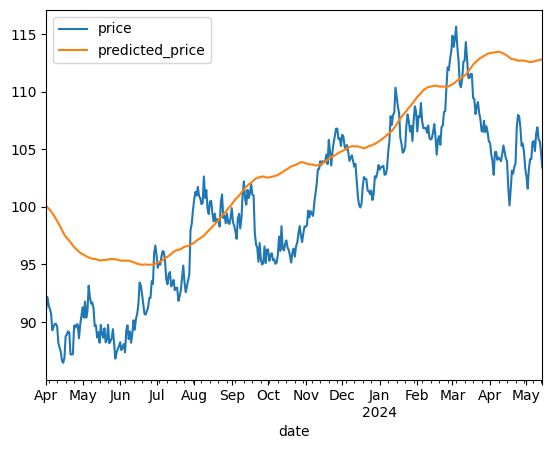

In [ ]:
result_df.plot()

### What is `nr_params` parameter
The `nr_params` parameter in the `class _TCNModlue` refers to the number of parameters of the likelihood function, or simply the number of parameters the model outputs for each time step.

### Role of `nr_params`
#### 1. Deterministic vs. Probabilistic Models:
* In deterministic forecasting models, each output time step typically corresponds to a single value (e.g., the predicted value at that time step).
* In probabilistic forecasting models, each output time step might correspond to multiple values representing a probability distribution (e.g., the mean and variance of a Gaussian distribution).

#### 2. Number of Parameters:
* `nu_params` determines how many values are predicted for each time step in the output sequence.
* For deterministic models, `nr_params` is usually `1` (one predicted value per time step).
* For probabilistic models, `nr_params` might `2` or more, depending on the type of distribution being modeled (e.g., `2` for a Gaussian distibution with mean and variance).

### Example in the Context of TCN
In the `TCNModule`:
* `nr_params` is used to define the number of output parameters per time step.
* The model's output dimension is influenced by this parameter to accommodate the number of parameters being predicted for each time step.

### Code Snippet for Context
Here is how `nr_params` might be used in the `TCNModule`:
```python
class _TCNModule(PLPastCovariatesModule):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: Optional[int],
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        target_length: int,
        dropout: float,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_length = target_length
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base

        # If num_layers is not passed, compute number of layers needed for full history coverage
        if num_layers is None and dilation_base > 1:
            num_layers = math.ceil(
                math.log(
                    (self.input_chunk_length - 1)
                    * (dilation_base - 1)
                    / (kernel_size - 1)
                    / 2
                    + 1,
                    dilation_base,
                )
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        elif num_layers is None:
            num_layers = math.ceil(
                (self.input_chunk_length - 1) / (kernel_size - 1) / 2
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        self.num_layers = num_layers

        # Building TCN module
        self.res_blocks_list = []
        for i in range(num_layers):
            res_block = _ResidualBlock(
                num_filters=num_filters,
                kernel_size=kernel_size,
                dilation_base=dilation_base,
                dropout=dropout,
                weight_norm=weight_norm,
                nr_blocks_below=i,
                num_layers=num_layers,
                input_size=self.input_size,
                target_size=target_size * nr_params,  # Note the use of nr_params here
            )
            self.res_blocks_list.append(res_block)
        self.res_blocks = nn.ModuleList(self.res_blocks_list)

    @io_processor
    def forward(self, x_in: Tuple):
        x, _ = x_in
        # data is of size (batch_size, input_chunk_length, input_size)
        batch_size = x.size(0)
        x = x.transpose(1, 2)

        for res_block in self.res_blocks_list:
            x = res_block(x)

        x = x.transpose(1, 2)
        x = x.view(
            batch_size, self.input_chunk_length, self.target_size, self.nr_params  # Note the use of nr_params here
        )

        return x

    @property
    def first_prediction_index(self) -> int:
        return -self.output_chunk_length
```

### Summary
THe `nr_parms` parameter determines how many values the model outputs for each time step. It is particularly relevant for probabilistic models where each time step prediction may involve multiple parameters to describe a probability distribution. This parameter ensures that the output dimensions are set correctly to accommodate the number of predicted parameters per time step.


#### Example result by using `nr_params`

Let's explore an example where `nr_params` is used in both deterministic and probabilistic forecasting contexts.

### Deterministic Forecasting Example
In deterministic forecasting, each time step output corresponds to a single predicted vale.

#### Example:
* **nr_params = 1**
* Input sequence length: 24
* Output sequence length: 12
* Output for each time step: 1 predicted vale

#### Result:
For a single batch (assuming **batch_size = 32**), the model output shape would be:

$$ Output Shape = (32, 12, 1) $$

Each batch contains 32 sequences, each sequence predicts 12 future time steps, and each time step has a single predicted value.

### Probabilistic Forecasting Example
In probabilistic forecasting, each time step output corresponds to multiple predicted values, such as the parameters of a probability distribution (e.g., mean and variance for a Gaussian distribution).

#### Example:
* **nr_params = 2** (e.g., mean and variance for a Gaussian distribution)
* Input sequence length: 24
* Output sequence length: 12
* Output for each time step: 2 predicted values (mean and variance)

#### Result:
For a single batch (assuming **batch_size = 32**), the model output shape would be:

$$ Output Shape = (32, 12, 2) $$

Each batch contains 32 sequences, each sequence predicts 12 future time steps, and each time step has two predicted values (mean and variance).

### Example Code Snippet


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Dummy data
batch_size = 32
input_chunk_length = 24
output_chunk_length = 12
input_size = 10  # Number of features
num_samples = 100

# Generating random data
X = torch.randn(num_samples, input_chunk_length, input_size)
y = torch.randn(num_samples, output_chunk_length, 1)

# Create a DataLoader
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch_x, batch_y in loader:
    print(f"Batch X Shape: {batch_x.shape}")
    print(f"Batch Y Shape: {batch_y.shape}")
    break

Batch X Shape: torch.Size([32, 24, 10])
Batch Y Shape: torch.Size([32, 12, 1])


In [ ]:
# Define a simple TCN model
class SimpleTCN(nn.Module):
    def __init__(self, input_size, output_chunk_length, num_layers, num_filters, kernel_size, dilation_base, nr_params):
        super(SimpleTCN, self).__init__()
        self.num_layers = num_layers
        self.nr_params = nr_params
        self.output_chunk_length = output_chunk_length

        self.res_blocks = nn.ModuleList([
            nn.Conv1d(
                in_channels=input_size if i == 0 else num_filters,
                out_channels=num_filters,
                kernel_size=kernel_size,
                dilation=dilation_base ** i,
                padding=(dilation_base ** i) * (kernel_size - 1) // 2
            ) for i in range(num_layers)
        ])

        self.final_layer = nn.Conv1d(num_filters, nr_params, kernel_size=1)

    def forward(self, x):
        x = x.transpose(1, 2)  # Change to (batch_size, input_size, input_chunk_length)
        for layer in self.res_blocks:
            x = F.relu(layer(x))
        x = self.final_layer(x)
        x = x.transpose(1, 2)  # Change back to (batch_size, input_chunk_length, nr_params)

        # Slice the last output_chunk_length steps
        x = x[:, -self.output_chunk_length:, :]  # (batch_size, output_chunk_length, nr_params)

        return x

In [ ]:
# Example with deterministic forecasting (nr_params = 1)
nr_params = 1
model = SimpleTCN(input_size, output_chunk_length, num_layers=3, num_filters=16, kernel_size=3, dilation_base=2, nr_params=nr_params)

for batch_x, batch_y in loader:
    output = model(batch_x)
    print(f"Deterministic Output Shape: {output.shape}")
    # Expected shape: (batch_size, output_chunk_length, nr_params)
    break

Deterministic Output Shape: torch.Size([32, 12, 1])


In [ ]:
# Example with probabilistic forecasting (nr_params = 2)
nr_params = 2
model = SimpleTCN(input_size, output_chunk_length, num_layers=3, num_filters=16, kernel_size=3, dilation_base=2, nr_params=nr_params)

for batch_x, batch_y in loader:
    output = model(batch_x)
    print(f"Probabilistic Output Shape: {output.shape}")
    # Expected shape: (batch_size, output_chunk_length, nr_params)
    break

Probabilistic Output Shape: torch.Size([32, 12, 2])


#### Explanation:
1. **Model Definition**:
    * **self.final_layer** is defined to output **nr_params** channels.
2. **Forward Pass**:
    * The input tensor is transposed for the convolutional layers.
    * After passing through the residual blocks and the final layer, the tensor is transposed back.
    * The output tensor is sliced to select the last **output_chunk_length** steps, ensuring the shape is **(batch_size, output_chunk_length, nr_params)**.

#### Expected Results:
1. **Deterministic Forecasting**:
    * **output_chunk_length = 12**
    * **nr_params = 1**
    * Expected output shape: **[32, 12, 1]**

2. **Probabilistic Forecasting**:
    * **output_chunk_length = 12**
    * **nr_params = 2**
    * Expected output shape: **[32, 12, 2]**


### about `x_in` parameter in forward()

### Context of `x_in`
In the Darts library, the **forward** method of a PyTorch module is where the input data passes through the network layers to produce the output. In the **class _TCNModule**, the **forward** method looks like this:
```python
@io_processor
def forward(self, x_in: Tuple):
    x, _ = x_in
    # data is of size (batch_size, input_chunk_length, input_size)
    batch_size = x.size(0)
    x = x.transpose(1, 2)

    for res_block in self.res_blocks_list:
        x = res_block(x)

    x = x.transpose(1, 2)
    x = x.view(
        batch_size, self.input_chunk_length, self.target_size, self.nr_params
    )

    return x
```

### Structure of `x_in`
The **x_in**paramter is a tuple, which typically contains multiple elements. In this specific case:
* **x_in** contains **(x, some_other_value)**.
* **x** is the primary input tensor.
* **some_other_value** can be additional information required for processing, such as past covariates, future covariates, or any other relevant data. However, in this context, is is not used directly in the forward pass.

### Why Use a Tuple?
#### 1. Multiple Inputs:
* Time series forecasting models often require multiple inputs. For example, a model might need past covariates along with the target series.
* Using a tuple allows passing multiple inputs conveniently.

#### 2. Flexibility:
* By structuring inputs as a tuple, the forward method can easily handle and extend to different types of inputs without changing the method signature.
* This is particularly useful in frameworks like Darts, which aim to provide flexible and reusable model components.

### Extracting the First Value
In the **forward** method, only the first value of the tuple (**x**) is used:
```python
x, _ = x_in
```

### Reason for Using Only the First Value
#### 1. Primary Input:
* The primary input tensor **x** is the main data that the model processes to produce predictions.
* In this cotext, **x** contains the historical time series data that the TCN uses to make forecasts.

#### 2. Ignoring Additional Inputs:
* The underscore **_** is a convention in Python indicating that the additional value is not used.
* This approach keeps the method signature flexible, allowing for potential future use of the second value if needed without altering the interface.

### Example of `x_in` Cntents
Assume we have:
* **batch_size = 32**
* **input_chunk_length = 24**
* **input_size = 10**

Then, **x** might be a tensor of shape **(32, 24, 10)** representing the input data.

```python
x_in = (torch.randn(32, 24, 10), some_other_value)
```

### Practical Explanation
* The **forward** method extracts **x** from **x_in** and processes it through the TCN layers.
* The second value (**some_other_value**) is present but not used in this specific implementation.

### Summary
The **x_in** parameter in the **forward** method Of **class _TCNModule** is a tuple to allow multiple inputs, providing flexibility and scalability in handling different types of data. The primary input tensor **x** is extracted and used for the forward pass, while the second value is ignored in this context but provides a placeholder for additional data if needed in the future. This design pattern helps keep the model interface clean and adaptable.


### the role of `def first_prediction_index()`
The `firtst_prediction_index` function in the `class _TCNModule` plays an important role in determining where the predictions start in the output sequence.

### Context of `first_prediciton_index`
In time series forecasting, especially with sequence models like TCNs, it is crucial to know from which point in the output sequence the model's predictions are considered valid.

### Function Definition
```python
def first_prediction_index(self) -> int:
    return -self.output_chunk_length
```

### Explanation
#### 1. Output Sequence Length:
* **self.output_chunk_length** is the length of the output sequence that the model predicts at each forward pass.
* For instance, if **outout_chunk_length = 12**, the model is predicting 12 future time steps for each input sequence.

#### 2. Negative Indexing:
* The function returns **-self.output_chunk_length**, which is the negative value of the output chunk length.
* In Python, negative indexing is used to count from the end of a list or sequence.
* **-self.output_chunk_length** essentially points to the start of the valid prediction window within the output sequence.

### Role in Time Series Forecasting
#### 1. Valid Prediction Start:
* The **first_prediction_index** function tells the system where the valid predictions start in the output sequence.
* This is useful for aligning the model's predictions with the actual time steps in the input sequence.
#### 2. Prediction Alignment:
* When the model makes a prediction, the output sequence might contain some values that are not immediately part of the valid prediction window.
* By returning **-self.output_chunk_length**, the function ensures that only the last **output_chunk_length** values in the output sequence are considered as valid predictions.
#### 3. Model Integration:
* This function can be used by other parts of the model or the forecasting framework to correctly align the predictions with the actual future time steps.
* It helps in slicing the output tensor to retrieve the valid predicted values, ignoring any padding or intial sequence values that are not part of the forecast.

### Practical Example
Assume **output_chunk_length = 12**. The function **first_prediction_index** will return **-12**.

* If the model's output sequence (before slicing) looks like **[... some initial values ..., valid_prediction]**, the valid predictions start from index **-12**.
* This ensures that only the last 12 values are considered for the final forecast.

### Conclusion
The **first_prediction_index** function is crucial for aligning and validating the model's predictions in time series forecasting. It helps in determining the starting point of the valid predictions within the output sequence, ensuring that the predictions correspond accurately to the intended future time steps. This alignment is essential for the correct interpretation and utilization of the model's forecasts.

### What is `Past Covariates`

Dartsでは、特徴量を`past_covariates`という引数に別に渡して、モデルを構築するので、Dartsの**PLPastCovariatesModule**を継承している。

In the context of time series forecasting and models like the Temporal Convolutional Network (TCN), "past covariates" refer to additional time-dependent variables (or features) that are available for the same time periods as the target time series and can be used to improve the accuracy of the forecast.

### Understanding Covariates
Covariates are additional variables that provide context or supplementary information about the target variable you are trying to forecast. They can be classified into two main types:

1. **Past Covariates**: Histrical values of variables that are known for the same time period as the target series.
2. **Future Covariates**: Known future values of variables that can be used to predict the target variable.

### Example of Past Covariates
Consider a time series forecasting problem where the target variable is the sales of a product. Past covariates could include:

* Historical weather data (e.g., temperature, humidity) if weather impacts sales.
* Historical promotional activities (e.g., discounts, advertising).
* Historical economic indicators (e.g., consumer confidence index).
* Other related time series (e.g., sales of related products).

### Why Use Past Covariates?
1. **Improved Forecasting Accuracy**: By incorporating relevalt past covariates, the model can capture more complex patterns and relationships in the data, leading to better forecasts.
2. **Contextual Information**: Covariates provide additional context that can help the model understand the factors driving the target variable's behavior.
3. **Captureing External Influences**: Covariates can capture external influences that directly or indirectly affects the target variable.

### Incorporating Past Covariates in a Model
In models like the TCN, past covariates are included as additional input features. The model processes both the target time series and the past covariates to generate forecasts.

#### Example in Darts
Here's an example of how past covariates can be used with a TCN model in the Darts library:


In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 29.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-non

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_bloc

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

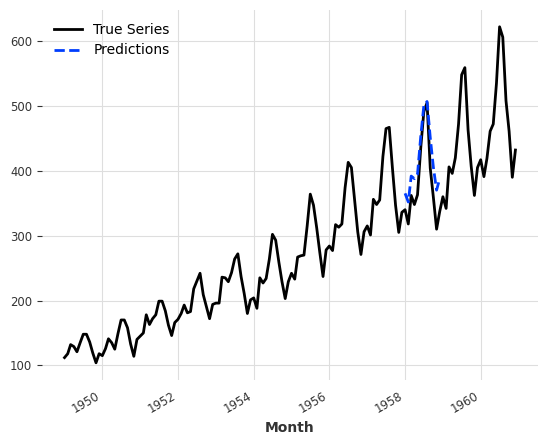

In [ ]:
from darts.models import TCNModel
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries
import matplotlib.pyplot as plt

# Load the target time series (e.g., monthly air passengers data)
series = AirPassengersDataset().load()

# Generate a past covariate (e.g., month of the year as a cyclic feature)
covariates = datetime_attribute_timeseries(
    series.time_index, attribute="month", cyclic=True, one_hot=False
)

# Create the TCN model
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    kernel_size=3,
    num_filters=16,
    num_layers=3,
    dropout=0.2,
    weight_norm=True,
    random_state=42
)

# Split the data into training and validation sets
train_series = series[:-36]
val_series = series[-36:]

# Ensure covariates cover the required range for training and prediction
train_covariates = covariates[:len(train_series)]
val_covariates = covariates[-(len(val_series) + model.output_chunk_length):]

# Fit the model with the past covariates
model.fit(train_series, past_covariates=train_covariates)

# Make predictions
pred_series = model.predict(n=12, series=train_series, past_covariates=covariates)

# Plot the results
series.plot(label='True Series')
pred_series.plot(label='Predictions', linestyle='dashed')
plt.legend()
plt.show()


#### Explanation:

1. **Load Data**: Load the target time series (e.g., monthly air passengers data).
2. **Generate Past Covariates**: Create a time series of past covariates (e.g., month of the year as a cyclic feature).
3. **Create Model**: Initialize the TCN model with specified hyperparameters.
4. **Train-Validation Split**: Split the data into training and validation sets.
5. **Fit Model**: Train the model using the target series and the past covariates.
6. **Make Predictions**: Generate forecasts using the trained model and past covariates.

#### Summary

- **Past Covariates**: Additional historical time-dependent variables that provide supplementary information about the target series.
- **Purpose**: Improve forecasting accuracy by capturing more complex patterns and relationships.
- **Implementation**: Incorporated as additional input features in the model, processed along with the target series to generate forecasts.

Using past covariates effectively can significantly enhance the performance of time series forecasting models. If you have any further questions or need more details, feel free to ask!

※ 上記、Dartsでの追加特徴量コードのpytorch版は、以下のnotebook参照

* difference_of _dealing_with_features_in_Darts.ipynb

## ３. TCNModel class

# ※※※ここから